In [1]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Model without transformation - Simple Approach

In [3]:
data_df = pd.read_excel(r'MMM.xlsx')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  200 non-null    datetime64[ns]
 1   TV                    201 non-null    float64       
 2   Radio                 201 non-null    float64       
 3   Banners               201 non-null    float64       
 4   Sales                 200 non-null    float64       
 5   Predicted Sales       200 non-null    float64       
 6   Correction Factor     200 non-null    float64       
 7   TV contribution       200 non-null    float64       
 8   Radio Contribution    200 non-null    float64       
 9   Banners Contribution  200 non-null    float64       
 10  Base Sales            201 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 17.4 KB


In [4]:
data_df = data_df[['Date','TV','Radio','Banners','Sales']]
data_df.describe()

,TV,Radio,Banners,Sales
count,201.000000,201.000000,201.000000,200.000000
mean,5863.099801,4405.144378,3026.313532,10668.141500
std,41624.590976,31171.106263,21363.101012,2700.706683
min,0.000000,0.000000,0.000000,4532.330000
25%,0.000000,0.000000,1662.350000,8396.942500
50%,0.000000,0.000000,1919.190000,10853.105000
75%,8045.440000,4650.060000,2081.040000,12566.995000
max,589241.530000,442717.010000,304144.510000,17668.340000


<AxesSubplot:>

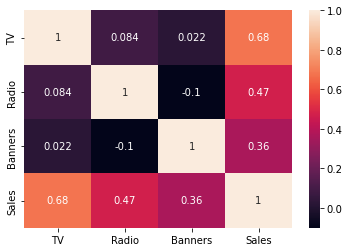

In [12]:
sns.heatmap(data_df.corr(),annot=True)

In [5]:
X = data_df[['TV','Radio','Banners']]
y = data_df[['Sales']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=101)

In [7]:
LinearRegressionmodel = LinearRegression()
LinearRegressionmodel.fit(X_train,y_train)

LinearRegression()

In [8]:
prediction = LinearRegressionmodel.predict(X_test)

In [10]:
print(LinearRegressionmodel.score(X_test,y_test))
rmse=np.sqrt(mean_squared_error(y_test,prediction))
print(rmse)

0.8467141226085568
949.7791229347195


In [11]:
LinearRegressionmodel.coef_

array([[0.35613285, 0.48967464, 1.19823611]])

In [13]:
LinearRegressionmodel.intercept_

array([6719.60646416])

In [14]:
X = sm.add_constant(X)
statslinearmodel = sm.OLS(y,X).fit()
print(statslinearmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     234.8
Date:                Fri, 29 Apr 2022   Prob (F-statistic):           1.28e-64
Time:                        12:24:40   Log-Likelihood:                -1711.1
No. Observations:                 200   AIC:                             3430.
Df Residuals:                     196   BIC:                             3443.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6678.3969    209.575     31.866      0.0

In [21]:
plot_df = data_df[['Date','TV contribution','Radio Contribution','Banners Contribution','Predicted Sales','Base Sales']]
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  200 non-null    object 
 1   TV contribution       200 non-null    float64
 2   Radio Contribution    200 non-null    float64
 3   Banners Contribution  200 non-null    float64
 4   Predicted Sales       200 non-null    float64
 5   Base Sales            200 non-null    float64
dtypes: float64(5), object(1)
memory usage: 9.5+ KB


In [38]:
sns.set_theme()
color_map=['blue','yellow','orange','green']

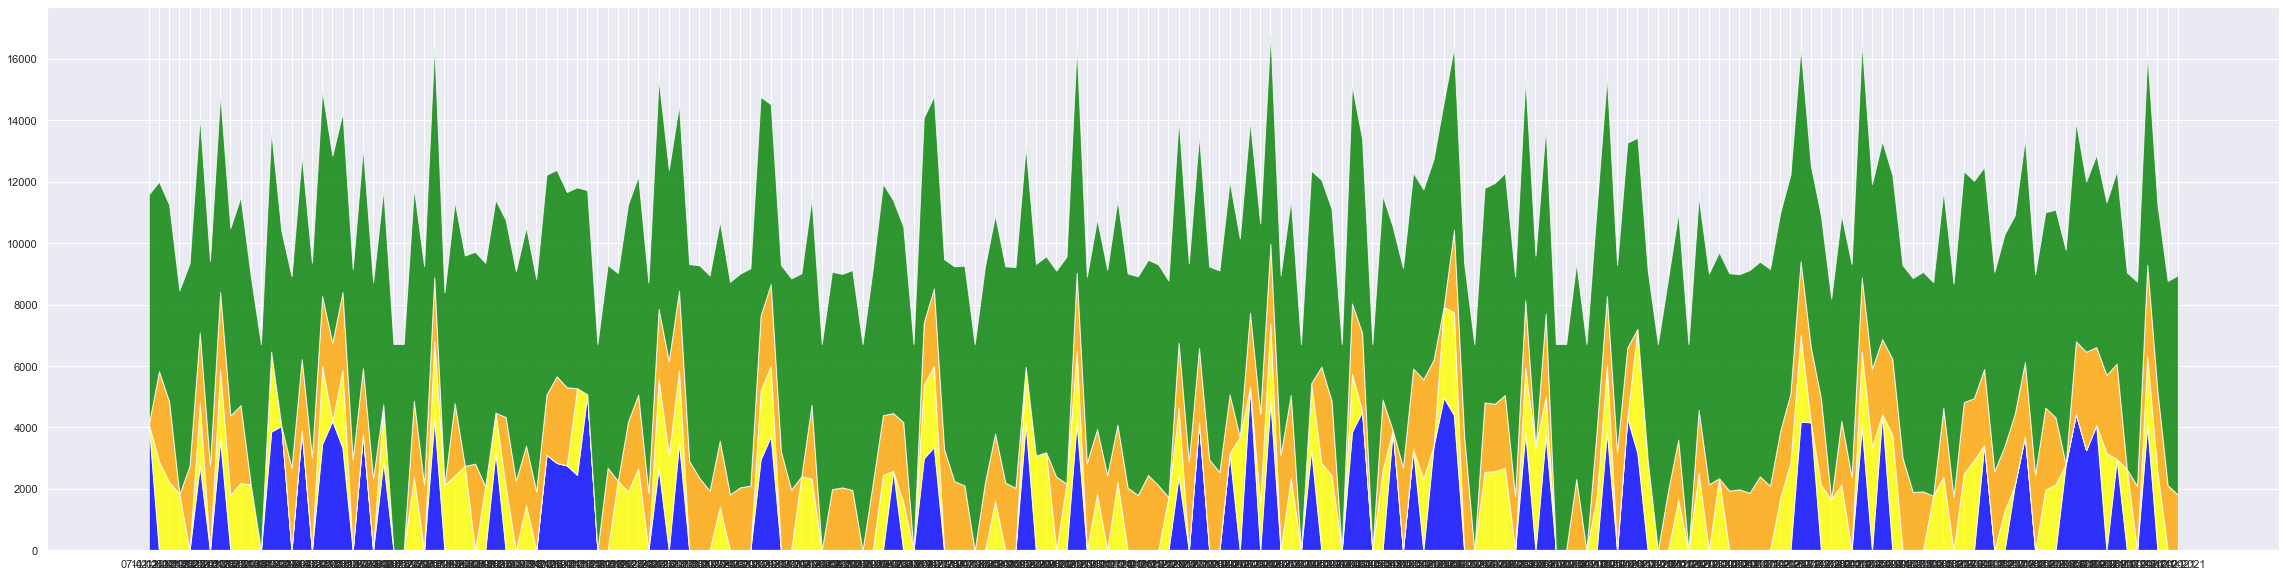

In [69]:
plt.figure(figsize=(40,10))
plt.stackplot(plot_df.Date,plot_df['TV contribution']
              ,plot_df['Radio Contribution'],plot_df['Banners Contribution'],plot_df['Base Sales'],labels=['TV','Radio','Banner','Base Sales'],colors=color_map,alpha=0.8)
#plt.xaxis.set_major_locator(mdates.WeekdayLocator(interval=30))

## Model with Transformation - Upgraded approach ##


In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array
class ExponentialSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, a=1.):
        self.a = a
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) # from BaseEstimator
        return self
    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) # from BaseEstimator
        return 1 - np.exp(-self.a*X)

In [37]:
from scipy.signal import convolve2d
import numpy as np
class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self
    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
adstock = ColumnTransformer(
    [
     ('TV_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['TV']),
     ('Radio_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Radio']),
     ('Banners_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Banners']),
    ],
    remainder='passthrough'
)
model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])

In [64]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import UniformDistribution, IntUniformDistribution
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
tuned_model = OptunaSearchCV(
    estimator=model,
    param_distributions={
        'adstock__TV_pipe__carryover__strength': UniformDistribution(0, 1),
        'adstock__TV_pipe__carryover__length': IntUniformDistribution(0, 6),
        'adstock__TV_pipe__saturation__a': UniformDistribution(0,0.01),
        'adstock__Radio_pipe__carryover__strength': UniformDistribution(0, 1),
        'adstock__Radio_pipe__carryover__length': IntUniformDistribution(0, 6),
        'adstock__Radio_pipe__saturation__a': UniformDistribution(0,0.01),
        'adstock__Banners_pipe__carryover__strength': UniformDistribution(0, 1),
        'adstock__Banners_pipe__carryover__length': IntUniformDistribution(0, 6),
        'adstock__Banners_pipe__saturation__a': UniformDistribution(0,0.01),
    },
    n_trials=1000,
    cv=TimeSeriesSplit(),
    random_state=101
)

In [ ]:
result = tuned_model.fit(X, y)

In [67]:
print(result.best_params_)
print(result.best_estimator_.named_steps['regression'].coef_)
print(result.best_estimator_.named_steps['regression'].intercept_)

{'adstock__TV_pipe__carryover__strength': 0.4994828701583125, 'adstock__TV_pipe__carryover__length': 3, 'adstock__TV_pipe__saturation__a': 4.652123003925007e-06, 'adstock__Radio_pipe__carryover__strength': 0.06974770645054024, 'adstock__Radio_pipe__carryover__length': 4, 'adstock__Radio_pipe__saturation__a': 0.0006895057999109585, 'adstock__Banners_pipe__carryover__strength': 0.35515291361244533, 'adstock__Banners_pipe__carryover__length': 0, 'adstock__Banners_pipe__saturation__a': 2.484621038953633e-06}
[[ 81710.1607088    2936.75482278 503249.21570758]]
[5263.15176007]


[I 2022-05-03 17:50:02,326] Trial 771 finished with value: 0.6900757459755482 and parameters: {'adstock__TV_pipe__carryover__strength': 0.4792061507755592, 'adstock__TV_pipe__carryover__length': 3, 'adstock__TV_pipe__saturation__a': 0.0008658300558411485, 'adstock__Radio_pipe__carryover__strength': 0.025850394314127487, 'adstock__Radio_pipe__carryover__length': 4, 'adstock__Radio_pipe__saturation__a': 0.0007191602097942892, 'adstock__Banners_pipe__carryover__strength': 0.33802191063034553, 'adstock__Banners_pipe__carryover__length': 0, 'adstock__Banners_pipe__saturation__a': 0.00047162278808122305}. Best is trial 668 with value: 0.9435914998102841.

## Future Sales Prediction ##

In [71]:
X_new = pd.DataFrame({
    'TV': [10000, 0, 0],
    'Radio': [0, 3000, 0],
    'Banners': [1000, 1000, 1000]
})
tuned_model.predict(X_new)

array([[10226.17620302],
       [10954.38509112],
       [ 7849.40300902]])

## ROI / Co-efficient Calculations ##

In [68]:
1-np.exp(-4.652123003925007e-06*81710.16)

0.31622455701439856

In [69]:
1-np.exp(-0.0006895057999109585*2936.75)

0.8679937696500114

In [70]:
1-np.exp(-2.484621038953633e-06*503249.215)

0.7136050817019809

## Saturation Plot ##

In [72]:
df_transform = pd.DataFrame(columns=['TV_saturation', 'Radio_saturation', 'Banners_saturation']) 
iterator = 0
a1 = 4.652123003925007e-06
a2 = 0.0006895057999109585
a3 = 2.484621038953633e-06

while iterator < 200:
    
    TV_Trans_value = 1-np.exp(-a1*X.iloc[iterator,0])
    Radio_Trans_value = 1-np.exp(-a2*X.iloc[iterator,1])
    Banners_Trans_value = 1-np.exp(-a3*X.iloc[iterator,2])
    df_transform.loc[iterator] = [TV_Trans_value, Radio_Trans_value, Banners_Trans_value]
    iterator += 1

In [74]:
plot_df = pd.concat([X,df_transform],axis = 1)

<AxesSubplot:xlabel='TV', ylabel='TV_saturation'>

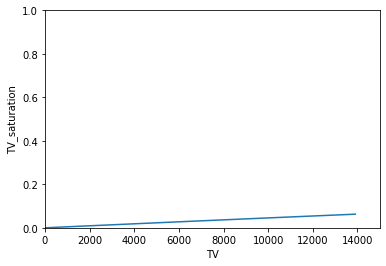

In [77]:
plt.ylim(0, 1)
plt.xlim(0,15000)
sns.lineplot(x=plot_df['TV'],y=plot_df['TV_saturation'],data=plot_df)

<AxesSubplot:xlabel='Radio', ylabel='Radio_saturation'>

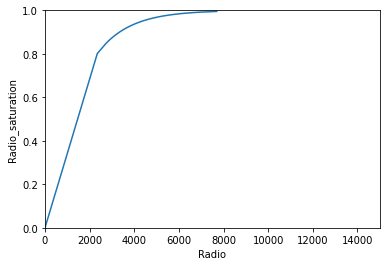

In [78]:
plt.ylim(0, 1)
plt.xlim(0,15000)
sns.lineplot(x=plot_df['Radio'],y=plot_df['Radio_saturation'],data=plot_df)

<AxesSubplot:xlabel='Banners', ylabel='Banners_saturation'>

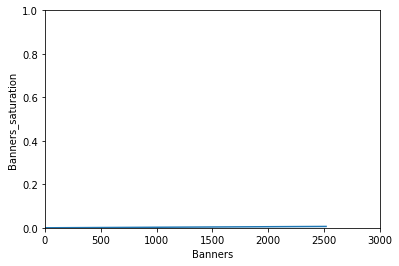

In [81]:
plt.ylim(0, 1)
plt.xlim(0,3000)
sns.lineplot(x=plot_df['Banners'],y=plot_df['Banners_saturation'],data=plot_df)

## Carryover Plot ##

In [85]:
df_transform_carryover_TV = pd.DataFrame(columns = ['TV_Trans_value_carryover'])
df_transform_carryover_Radio = pd.DataFrame(columns = ['Radio_Trans_value_carryover'])
df_transform_carryover_Banner = pd.DataFrame(columns = ['Banner_Trans_value_carryover'])
iterator = 0
index= 0
l1= 1
b1= 0.48

while iterator < 3:
    
    TV_Trans_value_carryover = X.iloc[index,0]*(b1**l1)  
    df_transform_carryover_TV.loc[iterator] = [TV_Trans_value_carryover]
    l1 += 1
    iterator += 1

In [86]:
iterator = 0
b2= 0.326
l2= 1
index = 187
while iterator < 4:
    Radio_Trans_value_carryover = X.iloc[index,1]*(b2**l2) 
    df_transform_carryover_Radio.loc[iterator] = [Radio_Trans_value_carryover]
    l2 += 1
    iterator += 1

In [94]:
weeks = ['188', '189', '190', '191']
df_transform_carryover_Radio['Weeks'] = weeks

In [93]:
weeks = ['1', '2', '3']
df_transform_carryover_TV['Weeks'] = weeks

<AxesSubplot:xlabel='Weeks', ylabel='TV_Trans_value_carryover'>

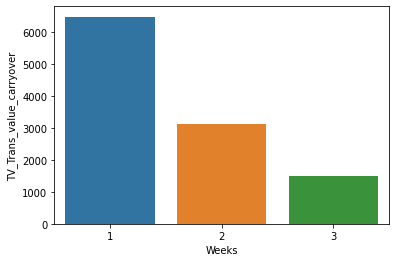

In [91]:
sns.barplot(x = df_transform_carryover_TV['Weeks'], y = df_transform_carryover_TV['TV_Trans_value_carryover'], data = df_transform_carryover_TV)

<AxesSubplot:xlabel='Weeks', ylabel='Radio_Trans_value_carryover'>

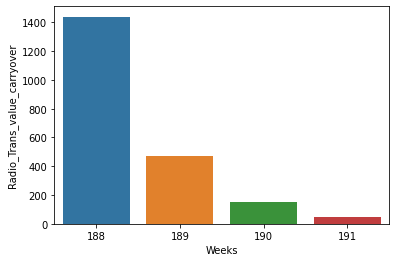

In [92]:
sns.barplot(x = df_transform_carryover_Radio['Weeks'], y = df_transform_carryover_Radio['Radio_Trans_value_carryover'], data = df_transform_carryover_TV)

In [ ]:
## 

In [ ]:
sns.set_theme()
color_map=['blue','yellow','orange','green']
plt.figure(figsize=(40,10))
plt.stackplot(plot_df.Date,plot_df['TV contribution']
              ,plot_df['Radio Contribution'],plot_df['Banners Contribution'],plot_df['Base Sales'],labels=['TV','Radio','Banner','Base Sales'],colors=color_map,alpha=0.8)